<a href="https://colab.research.google.com/github/manujism/1F_Results/blob/main/Updated_Client_Specific.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading and preparing data...
✅ Data preparation complete.

--- Goal Stress Test Setup ---
Enter a single percentage to increase all goal costs (e.g., 10 for 10%). Press Enter for 0%.
➡️ Stress factor for ALL goals (%): 50
✅ Stress factor applied.
➡️ How many simulations do you want to run? (Recommended: 10000): 1000

--- Running 1,000 main simulations for 'Current Strategy' ---

--- Running 1,000 main simulations for 'Suggested Strategy' ---

--- Running a single trace simulation for 'Current Strategy' ---

--- Running a single trace simulation for 'Suggested Strategy' ---


################################################################################
###                        COMPREHENSIVE SIMULATION ANALYSIS                         ###
################################################################################


                    1. Key Results Comparison
                             Current Strategy Suggested Strategy
Metric                                               

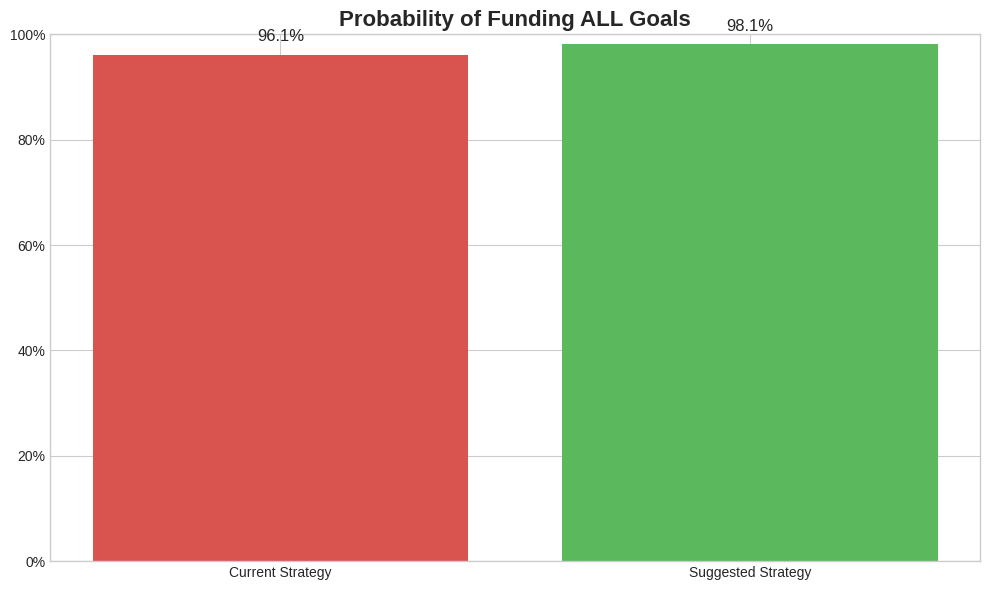

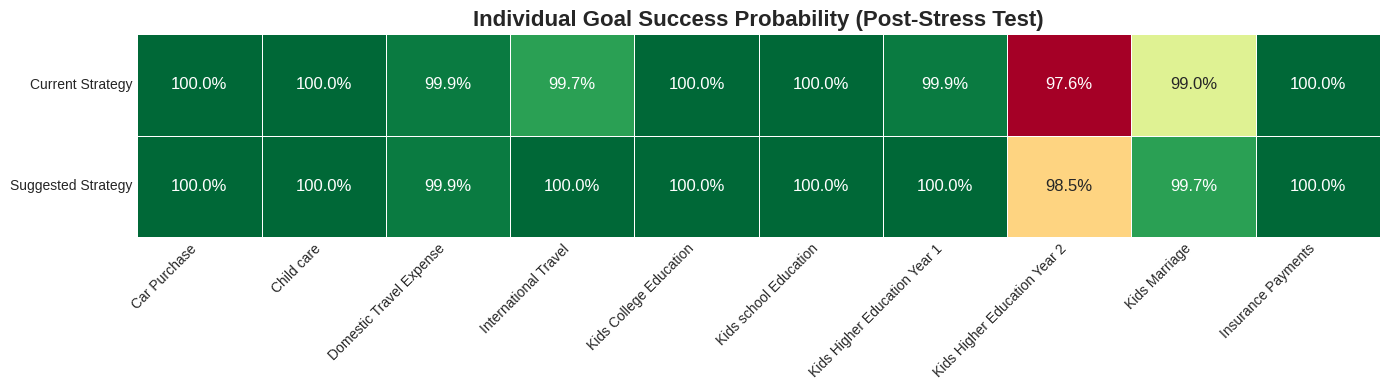

/tmp/ipython-input-2370182753.py:175: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


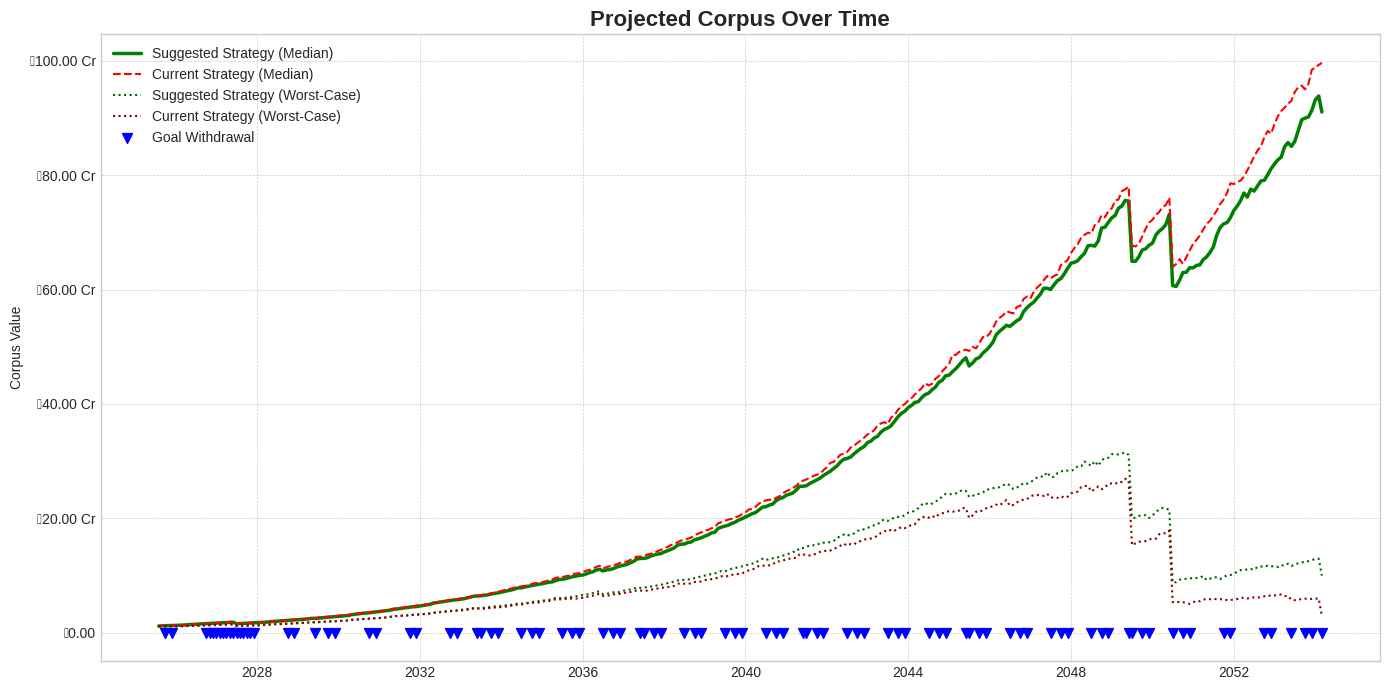

/tmp/ipython-input-2370182753.py:185: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  plt.legend(); plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


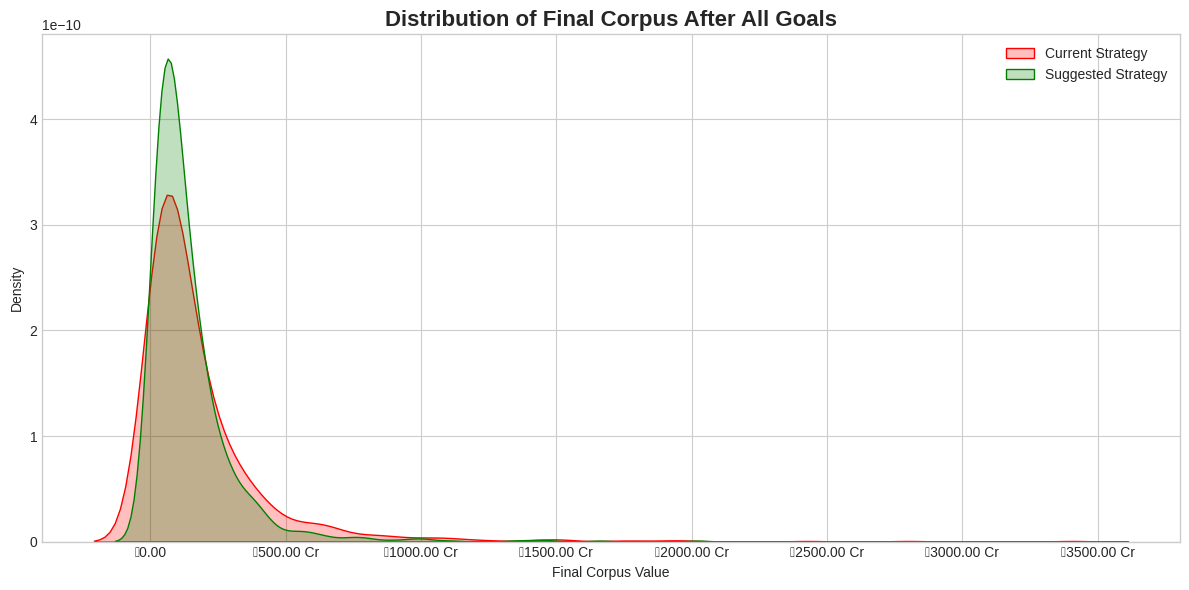


✅ All analyses complete.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from collections import Counter

# --- Helper function to format numbers into the Indian numbering system (Crores & Lakhs) ---
def format_indian_currency(num):
    """Converts a number to a string in Indian Crores/Lakhs format."""
    if pd.isna(num):
        return "₹0"
    num = float(num)
    sign = "(-)" if num < 0 else ""
    num = abs(num)

    if num >= 1_00_00_000:
        return f"{sign}₹{num / 1_00_00_000:.2f} Cr"
    elif num >= 1_00_000:
        return f"{sign}₹{num / 1_00_000:.2f} L"
    else:
        return f"{sign}₹{num:,.2f}"

# --- Monte Carlo Simulation Engine (Main) ---
def run_simulation(name, initial_corpus_weights, sip_weights, initial_investment, sip_schedule, stressed_goal_df, returns_df, num_simulations):
    """Runs a full, multi-path simulation to get aggregate statistics using stressed goal amounts."""
    print(f"\n--- Running {num_simulations:,} main simulations for '{name}' ---")
    investment_horizon_months = len(sip_schedule)
    goal_columns = stressed_goal_df.columns
    all_assets = list(set(initial_corpus_weights.keys()) | set(sip_weights.keys()))
    corpus_over_time_all_sims = np.zeros((num_simulations, investment_horizon_months))
    final_corpus_values = []
    goal_failure_counter = Counter()
    liquidity_failures = 0

    for i in range(num_simulations):
        corpus_by_asset = {asset: initial_investment * initial_corpus_weights.get(asset, 0) for asset in all_assets}
        for month in range(investment_horizon_months):
            total_corpus_before_actions = sum(corpus_by_asset.values())
            withdrawal_amount = stressed_goal_df.iloc[month].sum()

            if withdrawal_amount > total_corpus_before_actions:
                missed_goals = [goal for goal in goal_columns if stressed_goal_df.at[month, goal] > 0]
                goal_failure_counter.update(missed_goals)
                corpus_over_time_all_sims[i, month:] = 0
                liquidity_failures += 1
                break

            if withdrawal_amount > 0:
                reduction_factor = (total_corpus_before_actions - withdrawal_amount) / total_corpus_before_actions
                for asset in corpus_by_asset:
                    corpus_by_asset[asset] *= reduction_factor

            sip_this_month = sip_schedule[month]
            if sip_this_month > 0:
                for asset, weight in sip_weights.items():
                    corpus_by_asset[asset] = corpus_by_asset.get(asset, 0) + (sip_this_month * weight)

            random_returns_row = returns_df.sample(1).iloc[0]
            for asset in corpus_by_asset:
                asset_return = random_returns_row.get(asset, 0)
                corpus_by_asset[asset] *= (1 + asset_return)

            corpus_over_time_all_sims[i, month] = sum(corpus_by_asset.values())

        final_total_corpus = sum(corpus_by_asset.values())
        final_corpus_values.append(final_total_corpus if final_total_corpus >= 0 else 0)

    prob_all_goals = 1 - (liquidity_failures / num_simulations)
    goal_success_prob = {goal: 1 - (goal_failure_counter.get(goal, 0) / num_simulations) for goal in goal_columns if stressed_goal_df[goal].sum() > 0}

    return {
        'name': name, 'prob_all_goals': prob_all_goals, 'median_corpus': np.median(final_corpus_values),
        '5th_percentile_corpus': np.percentile(final_corpus_values, 5), 'final_corpus_values': final_corpus_values,
        'goal_success_prob': goal_success_prob, 'corpus_over_time_median': np.percentile(corpus_over_time_all_sims, 50, axis=0),
        'corpus_over_time_p5': np.percentile(corpus_over_time_all_sims, 5, axis=0)
    }

# --- Monte Carlo Simulation Engine (Trace for one run) ---
def run_simulation_with_trace(name, initial_corpus_weights, sip_weights, initial_investment, sip_schedule, stressed_goal_df, returns_df, dates):
    """Runs a single simulation and returns a detailed monthly DataFrame of its journey, including returns and allocations."""
    print(f"\n--- Running a single trace simulation for '{name}' ---")
    investment_horizon_months = len(sip_schedule)
    all_assets = list(set(initial_corpus_weights.keys()) | set(sip_weights.keys()))
    trace_data = []
    corpus_by_asset = {asset: initial_investment * initial_corpus_weights.get(asset, 0) for asset in all_assets}

    for month in range(investment_horizon_months):
        month_data = {'Month': dates.iloc[month].strftime('%b-%Y')}

        total_corpus_before_actions = sum(corpus_by_asset.values())
        month_data['Corpus_Start'] = total_corpus_before_actions

        withdrawal_amount = stressed_goal_df.iloc[month].sum()
        month_data['Withdrawal'] = withdrawal_amount
        if withdrawal_amount > 0 and total_corpus_before_actions > 0:
            reduction_factor = max(0, (total_corpus_before_actions - withdrawal_amount) / total_corpus_before_actions)
            for asset in corpus_by_asset:
                corpus_by_asset[asset] *= reduction_factor

        if sum(corpus_by_asset.values()) <= 0 and total_corpus_before_actions > 0 and withdrawal_amount > 0:
            for asset in all_assets: corpus_by_asset[asset] = 0

        sip_this_month = sip_schedule[month]
        month_data['SIP_Added'] = sip_this_month
        if sip_this_month > 0:
            for asset, weight in sip_weights.items():
                corpus_by_asset[asset] = corpus_by_asset.get(asset, 0) + (sip_this_month * weight)

        random_returns_row = returns_df.sample(1).iloc[0]
        for asset in all_assets:
            asset_return = random_returns_row.get(asset, 0)
            month_data[f"Return_{asset}"] = asset_return
            if asset in corpus_by_asset:
                corpus_by_asset[asset] *= (1 + asset_return)

        total_corpus_after_actions = sum(corpus_by_asset.values())
        month_data['Corpus_End'] = total_corpus_after_actions

        for asset in all_assets:
            asset_value = corpus_by_asset.get(asset, 0)
            month_data[asset] = asset_value
            month_data[f"Pct_{asset}"] = (asset_value / total_corpus_after_actions) if total_corpus_after_actions > 0 else 0

        trace_data.append(month_data)

        if total_corpus_after_actions <= 0 and withdrawal_amount > 0:
            break

    return pd.DataFrame(trace_data)

# --- Visualization Functions ---
def plot_success_probability_comparison(results_current, results_suggested):
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))
    portfolios = [results_current['name'], results_suggested['name']]
    probabilities = [results_current['prob_all_goals'], results_suggested['prob_all_goals']]
    colors = ['#d9534f', '#5cb85c']
    bars = ax.bar(portfolios, probabilities, color=colors)
    ax.set_ylim(0, 1)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
    ax.set_title('Probability of Funding ALL Goals', fontsize=16, weight='bold')
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.1%}', ha='center', va='bottom', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_goal_success_heatmap(results_current, results_suggested, stressed_goal_df):
    goals = [g for g in stressed_goal_df.columns if stressed_goal_df[g].sum() > 0]
    prob_data = {
        results_current['name']: [results_current['goal_success_prob'].get(g, 1.0) for g in goals],
        results_suggested['name']: [results_suggested['goal_success_prob'].get(g, 1.0) for g in goals]
    }
    prob_df = pd.DataFrame(prob_data, index=goals).T
    plt.figure(figsize=(14, 4))
    sns.heatmap(prob_df, annot=True, cmap='RdYlGn', fmt='.1%', linewidths=.5, cbar=False, annot_kws={"size": 12})
    plt.title('Individual Goal Success Probability (Post-Stress Test)', fontsize=16, weight='bold')
    plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_corpus_projections(results_current, results_suggested, stressed_goal_df, dates):
    plt.figure(figsize=(14, 7))
    plt.plot(dates, results_suggested['corpus_over_time_median'], label=f"{results_suggested['name']} (Median)", color='green', linewidth=2.5)
    plt.plot(dates, results_current['corpus_over_time_median'], label=f"{results_current['name']} (Median)", color='red', linestyle='--')
    plt.plot(dates, results_suggested['corpus_over_time_p5'], label=f"{results_suggested['name']} (Worst-Case)", color='darkgreen', linestyle=':')
    plt.plot(dates, results_current['corpus_over_time_p5'], label=f"{results_current['name']} (Worst-Case)", color='darkred', linestyle=':')
    withdrawal_dates = dates[stressed_goal_df.sum(axis=1) > 0]
    y_coords_for_scatter = np.zeros(len(withdrawal_dates))
    plt.scatter(withdrawal_dates, y_coords_for_scatter, marker='v', color='blue', s=50, zorder=5, label='Goal Withdrawal')
    plt.title('Projected Corpus Over Time', fontsize=16, weight='bold'); plt.ylabel('Corpus Value')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: format_indian_currency(y)))
    plt.legend(); plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

def plot_final_corpus_distribution(results_current, results_suggested):
    plt.figure(figsize=(12, 6))
    sns.kdeplot(results_current['final_corpus_values'], fill=True, label=results_current['name'], color='red')
    sns.kdeplot(results_suggested['final_corpus_values'], fill=True, label=results_suggested['name'], color='green')
    plt.title('Distribution of Final Corpus After All Goals', fontsize=16, weight='bold')
    plt.xlabel('Final Corpus Value')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: format_indian_currency(x)))
    plt.legend(); plt.tight_layout()
    plt.show()

# --- Main Execution Block ---
def main():
    CLIENT_DATA_FILE = 'Client Full Data.xlsx'
    RETURNS_FILE = 'Finalized Returns.xlsx'
    try:
        # --- 1. Data Loading and Preparation ---
        print("Loading and preparing data...")
        returns_df = pd.read_excel(RETURNS_FILE, sheet_name='Sheet2')
        returns_df.columns = returns_df.columns.str.strip()
        master_asset_list = returns_df.columns.tolist()
        returns_df[master_asset_list] = returns_df[master_asset_list].apply(pd.to_numeric, errors='coerce') / 100
        returns_df.dropna(subset=master_asset_list, inplace=True)

        client_goals_df = pd.read_excel(CLIENT_DATA_FILE, sheet_name='Sheet1', header=0)
        client_goals_df.dropna(subset=['Month'], inplace=True)
        client_goals_df['Month'] = pd.to_datetime(client_goals_df['Month'], format='%b-%y')
        dates = client_goals_df['Month']
        sip_schedule = pd.to_numeric(client_goals_df['Total SIP'], errors='coerce').fillna(0).values
        first_goal_idx = client_goals_df.columns.get_loc('Car Purchase')
        goal_cols = client_goals_df.columns[first_goal_idx:]
        goal_df = client_goals_df[goal_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
        print("✅ Data preparation complete.")

        # --- 2. User Inputs ---
        initial_investment = 11361117
        initial_corpus_weights = {'Flexi Cap': 0.2525,'Large Cap Index': 0.2525, 'Gold': 0.129, 'Debt': 0.366}
        current_sip_weights = {'Flexi Cap': 0.75, 'Debt': 0.25}
        suggested_sip_weights = {'Large Cap Index': 0.20, 'Flexi Cap': 0.40, 'Debt': 0.20, 'Gold': 0.20}

        # ▼▼▼ NEW: Ask user for a single Goal Stress Factor ▼▼▼
        stress_factor = 0.0
        print("\n--- Goal Stress Test Setup ---")
        print("Enter a single percentage to increase all goal costs (e.g., 10 for 10%). Press Enter for 0%.")
        while True:
            try:
                stress_input = input("➡️ Stress factor for ALL goals (%): ")
                if not stress_input:
                    stress_factor = 0.0
                    break
                stress_factor = float(stress_input)
                break
            except ValueError:
                print("⚠️ Invalid input. Please enter a number (e.g., 10 or 15.5).")

        stressed_goal_df = goal_df * (1 + stress_factor / 100)
        print("✅ Stress factor applied.")
        # ▲▲▲ END OF NEW SECTION ▲▲▲

        try:
            num_sims_input = input("➡️ How many simulations do you want to run? (Recommended: 10000): ")
            num_simulations = int(num_sims_input)
            if num_simulations <= 0:
                print("⚠️ Number must be positive. Defaulting to 10,000.")
                num_simulations = 10000
        except ValueError:
            print("⚠️ Invalid input. Please enter a whole number. Defaulting to 10,000.")
            num_simulations = 10000

        # --- 3. Run Main & Trace Simulations (using stressed goals) ---
        results_current_strategy = run_simulation("Current Strategy", initial_corpus_weights, current_sip_weights, initial_investment, sip_schedule, stressed_goal_df, returns_df, num_simulations)
        results_suggested_strategy = run_simulation("Suggested Strategy", initial_corpus_weights, suggested_sip_weights, initial_investment, sip_schedule, stressed_goal_df, returns_df, num_simulations)
        trace_df_current = run_simulation_with_trace("Current Strategy", initial_corpus_weights, current_sip_weights, initial_investment, sip_schedule, stressed_goal_df, returns_df, dates)
        trace_df_suggested = run_simulation_with_trace("Suggested Strategy", initial_corpus_weights, suggested_sip_weights, initial_investment, sip_schedule, stressed_goal_df, returns_df, dates)

        # --- 4. Display All Text-Based Analysis ---
        print("\n\n" + "#"*80)
        print("###" + " "*24 + "COMPREHENSIVE SIMULATION ANALYSIS" + " "*25 + "###")
        print("#"*80)

        summary_data = {
           "Metric": ["Overall Success Probability", "Median Final Corpus", "Worst-Case Corpus (5th %ile)"],
           "Current Strategy": [f"{results_current_strategy['prob_all_goals']:.1%}", format_indian_currency(results_current_strategy['median_corpus']), format_indian_currency(results_current_strategy['5th_percentile_corpus'])],
           "Suggested Strategy": [f"{results_suggested_strategy['prob_all_goals']:.1%}", format_indian_currency(results_suggested_strategy['median_corpus']), format_indian_currency(results_suggested_strategy['5th_percentile_corpus'])]
        }
        summary_df = pd.DataFrame(summary_data).set_index('Metric')
        print("\n\n" + "="*65); print(" " * 20 + "1. Key Results Comparison"); print("="*65)
        print(summary_df.to_string())

        all_assets = sorted(list(set(initial_corpus_weights.keys()) | set(current_sip_weights.keys()) | set(suggested_sip_weights.keys())))

        pd.set_option('display.max_rows', None)
        pd.set_option('display.width', 200)

        for strategy_name, trace_df in [("CURRENT", trace_df_current), ("SUGGESTED", trace_df_suggested)]:
            value_cols = ['Month', 'Corpus_Start', 'Withdrawal', 'SIP_Added', 'Corpus_End'] + [a for a in all_assets if a in trace_df.columns]
            analysis_cols = ['Month'] + [f"Return_{a}" for a in all_assets if f"Return_{a}" in trace_df.columns] + [f"Pct_{a}" for a in all_assets if f"Pct_{a}" in trace_df.columns]

            trace_values = trace_df[value_cols].copy()
            trace_analysis = trace_df[analysis_cols].copy()

            for col in value_cols:
                if col != 'Month': trace_values[col] = trace_values[col].apply(format_indian_currency)

            for col in analysis_cols:
                if 'Return_' in col: trace_analysis[col] = trace_analysis[col].map('{:.2%}'.format)
                elif 'Pct_' in col: trace_analysis[col] = trace_analysis[col].map('{:.1%}'.format)

            print("\n\n" + "="*80); print(f"                     4. MONTHLY BREAKDOWN (VALUES) - {strategy_name} STRATEGY"); print("="*80)
            print(trace_values.to_string())
            print("\n\n" + "="*80); print(f"                   4. MONTHLY BREAKDOWN (ANALYSIS) - {strategy_name} STRATEGY"); print("="*80)
            print(trace_analysis.to_string())

        # --- 5. Generate All Visuals (using stressed goals) ---
        print("\n\n" + "#"*80)
        print("###" + " "*30 + "GENERATING VISUALS" + " "*30 + "###")
        print("#"*80)
        plot_success_probability_comparison(results_current_strategy, results_suggested_strategy)
        plot_goal_success_heatmap(results_current_strategy, results_suggested_strategy, stressed_goal_df)
        plot_corpus_projections(results_current_strategy, results_suggested_strategy, stressed_goal_df, dates)
        plot_final_corpus_distribution(results_current_strategy, results_suggested_strategy)
        print("\n✅ All analyses complete.")

    except FileNotFoundError as e: print(f"\n❌ ERROR: Data file not found. Make sure '{e.filename}' is in the same folder.")
    except KeyError as e: print(f"\n❌ ERROR: A required column was not found: {e}. Check your Excel file column names.")
    except Exception as e: print(f"\n❌ An unexpected error occurred: {e}")

# --- Run the main function ---
if __name__ == '__main__':
    main()

